##### packages

In [82]:
import csv
import os
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
import torch
import torch.utils.data as data
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import librosa
from matplotlib.colors import hsv_to_rgb
from scipy.ndimage import gaussian_filter

##### loading data

In [2]:
with open('../../../moodo/dataset.csv') as file:
    reader = csv.reader(file)
    csv_dataset = np.array([row for row in reader])

csv_dataset = pd.read_csv("../../../moodo/dataset.csv", dtype=str) # read as strings
csv_dataset.set_index("SongID", inplace=True)

# ---------------------------------
# encoding emotions
emotions = csv_dataset["Emotion"].unique()
encoder = LabelEncoder()
encoder.fit(emotions)
csv_dataset["EmotionEncoded"] = encoder.transform(csv_dataset["Emotion"])
emotion_mapping = dict(zip(encoder.classes_, encoder.transform(encoder.classes_)))

print("Emotion Mapping:", emotion_mapping)

# ---------------------------------
df = pd.DataFrame(csv_dataset)
feature_dir = "../../../moodo/audio_features2"

final_data = []
for filename in os.listdir(feature_dir):
    song_id = filename.split('.')[0]
    file_path = os.path.join(feature_dir, filename)

    # shape: (n_segments, 13, 216)
    feature_matrix = np.load(file_path)
    
    metadata = df.drop(columns='Emotion').loc[song_id].values

    for segment in feature_matrix:
        row = np.hstack([segment.flatten(), metadata])  # 13x216 = 2808   + 6 (metadata) = 2814
        final_data.append(row)

final_data = np.array(final_data, dtype=float)

print("Final dataset shape:", final_data.shape)

Emotion Mapping: {'Anger': np.int64(0), 'Anticipation': np.int64(1), 'Calmness': np.int64(2), 'Dreamy': np.int64(3), 'Fear': np.int64(4), 'Gloominess': np.int64(5), 'Happiness': np.int64(6), 'Inspiring': np.int64(7), 'Joy': np.int64(8), 'Liveliness': np.int64(9), 'Longing': np.int64(10), 'Relaxed': np.int64(11), 'Sadness': np.int64(12), 'Surprise': np.int64(13)}
Final dataset shape: (996, 2814)


In [23]:
n_split = -6 # last 6 columns: H, S, V, Valence, Arousal, EmotionEncoded

features = final_data[:, :n_split]
labels = final_data[:, n_split:]

features_tensor = torch.tensor(features, dtype=torch.float32)
labels_tensor = torch.tensor(labels, dtype=torch.float32)
train_features, test_features, train_labels, test_labels = train_test_split(features_tensor, labels_tensor, test_size=0.2, random_state=0)
print("Train features shape:", train_features.shape, "Test features shape:", test_features.shape)
print("Train labels shape:", train_labels.shape, "Test labels shape:", test_labels.shape)

class AudioDataset(data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = AudioDataset(train_features, train_labels)
test_dataset = AudioDataset(test_features, test_labels)

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True, drop_last=True)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False, drop_last=True)

Train features shape: torch.Size([796, 2808]) Test features shape: torch.Size([200, 2808])
Train labels shape: torch.Size([796, 6]) Test labels shape: torch.Size([200, 6])


##### architecture

In [24]:
class AudioEmotionModel(nn.Module):
    def __init__(self):
        super(AudioEmotionModel, self).__init__()
        self.fc1 = nn.Linear(2808, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 256)
        self.fc4 = nn.Linear(256, 6)  # Output layer (H, S, V, valence, arousal, emotion index)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.fc1(x))
        x = self.relu(self.fc2(x))
        x = self.relu(self.fc3(x))
        x = self.fc4(x)
        return x

model = AudioEmotionModel()

##### training

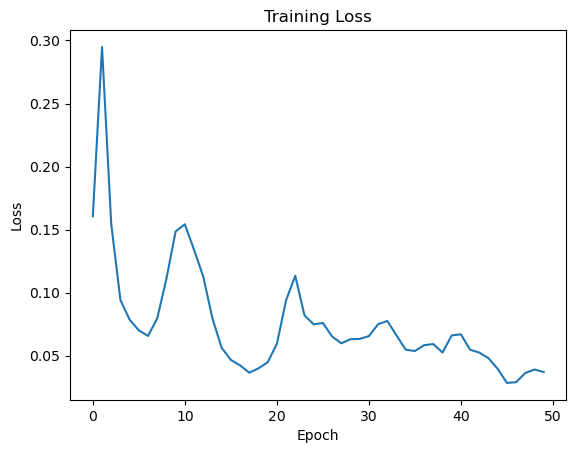

In [33]:
lr = 0.001
epochs = 50
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

losses = []
for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    
    for i, (inputs, targets) in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
    
    avg_loss = running_loss / len(train_loader)
    losses.append(avg_loss)
    print(f'Epoch {epoch+1}/{epochs}, Loss: {avg_loss:.4f}', end='\r')
    
# generate loss plot
plt.plot(losses)
plt.title('Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

##### testing

In [125]:
model.eval()  # Set model to evaluation mode
total_loss = 0.0

with torch.no_grad():
    for inputs, targets in test_loader:
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        total_loss += loss.item()
        
        predicted = torch.argmax(outputs[-1])
        decoded_emotion = encoder.inverse_transform([predicted.item()])[0]
        actual = torch.argmax(targets[-1])
        decoded_actual = encoder.inverse_transform([actual.item()])[0]
        # print(f'Predicted: {decoded_emotion} | Actual: {decoded_actual}')

avg_test_loss = total_loss / len(test_loader)
print(f'Test Loss: {avg_test_loss:.4f}')

Test Loss: 3.5001


##### applying elsewhere

In [122]:
class EmotionPredictor():
    def __init__(self, mp3_file):
        self.mp3_file = mp3_file
        
        with open('../../../moodo/dataset.csv') as file:
            reader = csv.reader(file)
            csv_dataset = np.array([row for row in reader])

        csv_dataset = pd.read_csv("../../../moodo/dataset.csv", dtype=str) # read as strings
        csv_dataset.set_index("SongID", inplace=True)

        emotions = csv_dataset["Emotion"].unique()
        self.encoder = LabelEncoder()
        self.encoder.fit(emotions)
        csv_dataset["EmotionEncoded"] = self.encoder.transform(csv_dataset["Emotion"])
        emotion_mapping = dict(zip(self.encoder.classes_, self.encoder.transform(self.encoder.classes_)))
        
    def extract_features(self, file_path, sr=22050, duration=5.0, hop_size=2.5):
        y, _ = librosa.load(file_path, sr=sr)
        segment_length = int(sr * duration)
        hop_length = int(sr * hop_size)

        features = []
        
        for start in range(0, len(y) - segment_length + 1, hop_length):
            y_segment = y[start:start + segment_length]
            
            mfcc = librosa.feature.mfcc(y=y_segment, sr=sr, n_mfcc=13)
            dcf = librosa.feature.delta(mfcc)

            features.append(dcf)

        return np.array(features)

    def predict(self):
        features = self.extract_features(self.mp3_file)
        
        output_emotions = []
        output_valence = []
        output_arousal = []
        output_hsv = []
        for segment in features:
            segment = torch.tensor(segment.flatten(), dtype=torch.float32)
            output = model(segment)
            predicted = torch.argmax(output[-1])
            decoded_emotion = self.encoder.inverse_transform([predicted.item()])[0]
            output_emotions.append(decoded_emotion)
            output_valence.append(output[-3].item())
            output_arousal.append(output[-2].item())
            output_hsv.append(output[-6:-3].tolist())
        
        return output_emotions, output_valence, output_arousal, output_hsv
    
    def display(self):
        output_emotions, output_valence, output_arousal, output_hsv = self.predict()

        # Create a grid for the background gradient
        valence_min, valence_max = min(output_valence), max(output_valence)
        arousal_min, arousal_max = min(output_arousal), max(output_arousal)
        
        # Create a 2D grid of valence and arousal values
        valence_grid, arousal_grid = np.meshgrid(np.linspace(valence_min, valence_max, 100),
                                                np.linspace(arousal_min, arousal_max, 100))
        
        # Create an empty array for the color gradient
        gradient_hsv_grid = np.zeros((100, 100, 3))

        # Smooth phase-like coloring
        for i in range(100):
            for j in range(100):
                # Compute hue based on valence and arousal, which will define the color phase
                hue = (valence_grid[i, j] - valence_min) / (valence_max - valence_min)  # Normalize
                saturation = 1  # Max saturation for vivid colors
                value = (arousal_grid[i, j] - arousal_min) / (arousal_max - arousal_min)  # Normalize
                
                gradient_hsv_grid[i, j] = [hue, saturation, value]

        # Apply Gaussian blur to create a more organic, smooth color blending effect
        gradient_hsv_grid = gaussian_filter(gradient_hsv_grid, sigma=4)

        # Convert the gradient to RGB for visualization
        gradient_rgb_grid = hsv_to_rgb(gradient_hsv_grid)

        # Plot the smooth, organic background gradient using imshow
        plt.imshow(gradient_rgb_grid, extent=[valence_min, valence_max, arousal_min, arousal_max], origin='lower', aspect='auto')

        # Increase the margins between the scatter points and the axis lines by adjusting axis limits only for scatter plot
        margin = 0.1  # Margin ratio (10% space between points and axis)
        
        # Set the limits for the scatter points to zoom out and create space
        plt.xlim(valence_min - (valence_max - valence_min) * margin, valence_max + (valence_max - valence_min) * margin)
        plt.ylim(arousal_min - (arousal_max - arousal_min) * margin, arousal_max + (arousal_max - arousal_min) * margin)

        # Plot the scatter points with a larger size and transparency to make them blend better with the background
        for i, (emotion, valence, arousal, hsv) in enumerate(zip(output_emotions, output_valence, output_arousal, output_hsv)):
            # Ensure that the scatter points' HSV are correctly converted to RGB
            scatter_rgb = hsv_to_rgb([hsv])  # Convert HSV to RGB
            plt.scatter(valence, arousal, c=[hsv], label=emotion, edgecolors="black", s=200, alpha=0.7)


        plt.title(f'Emotion-Color Prediction | {self.mp3_file}')
        plt.xticks([]), plt.yticks([])
        plt.xlabel(f'Emotion(s): {", ".join(set(output_emotions))}')
        plt.show()

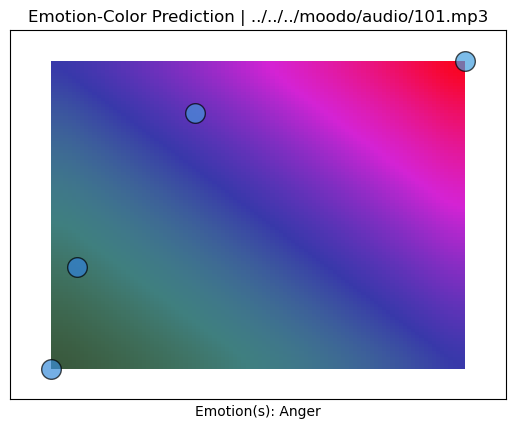

In [123]:
test = EmotionPredictor('../../../moodo/audio/101.mp3')
test.display()
